# **Can we build a de-bias classification model?**

In this project we will address algorithmic bias. We'll build a facial detection model that learns the latent variables underlying face image datasets and uses this to re-sample the training data. 


Definition:
Algorithmic bias describes systematic and repeatable errors in a computer system that create unfair outcomes, such as privileging one arbitrary group of users over others.

Cite: https://en.wikipedia.org/wiki/Algorithmic_bias

In [4]:
#DISCLAIMER: This project is based on the MITLearning experiment
#Import all relevant libraries needed
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=a40672241a11f21a21c775df89e51dae83758b1fadf3b815423c8fcf30831fd6
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


We will train the model on three datasets. In order to train our facial detection models, we will need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces).

1. CelebA Dataset.

2. Imagenet, will be our negative training set, based on the non-human images.

3. We will use the Fitzpatrick Scale skin type classification system. Where the images have been labelled 'lighter', 'Darker.'

Links: 
https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
https://www.tensorflow.org/datasets/catalog/imagenet2012
https://en.wikipedia.org/wiki/Fitzpatrick_scale




In [44]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

# Get the  images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/bp54q547mfg15ze/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [48]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Lets have a look at the size of the training dataset and assign a batch of size 400:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(400)

Training a deep learning model requires the dataset to be split into batches, then the deep learning algorithm(may be a neural network) has to store errors values for all those 100000 images in the memory and this will cause a great decrease in speed of training.

Cite: https://medium.com/analytics-vidhya/when-and-why-are-batches-used-in-machine-learning-acda4eb00763 

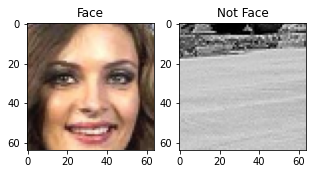

In [49]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Let us look at our dataset - Face vs Not face - We do this to see that our data is loaded and categorized correctly.

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 37 
idx_not_face = 37 

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

The Aims of the project: 
The aim is to build a model that trains on CelebA dataset and achieves high classification accuracy on the test dataset across all demographics.


Cite: https://arxiv.org/abs/2103.06179#:~:text=Bias%20in%20classifiers%20is%20a,relevant%20features%20and%20irrelevant%20ones.

Cite: https://blog.taus.net/9-types-of-data-bias-in-machine-learning

We can now train and define a CNN (Convolutional neural network) model.
The reason for choosing CNN to train the classification model is because the structure of the model is similar to the classical LeNet-5 model, but they are different on some parameters, such as input data, network width and full connection layer.

Cite: https://www.tandfonline.com/doi/full/10.1080/21642583.2020.1836526

Definition: In deep learning, a convolutional neural network is a class of Artificial Neural Network, most commonly applied to analyze visual imagery.(Wikipedia)

In [8]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Define the CNN model
#I have chosen sigmoid activation as it is known to work better with classification models.

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='sigmoid')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='sigmoid')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

#I have chosen sigmoid acitivation as it is known to work better with classification.

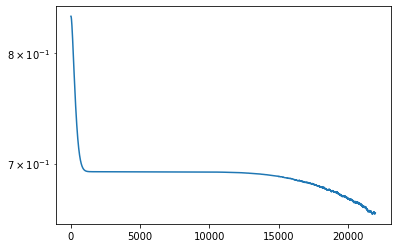

100%|██████████| 2198/2198 [04:25<00:00,  8.28it/s]


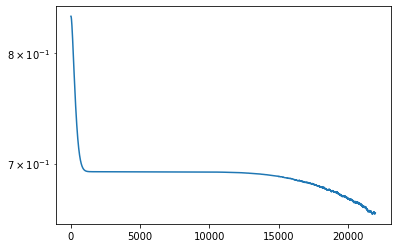

In [9]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb


#Train the standard CNN
#https://www.freecodecamp.org/news/how-to-pick-the-best-learning-rate-for-your-machine-learning-project-9c28865039a8/

# Training hyperparameters
batch_size = 50
num_epochs = 10  
learning_rate = 5e-7

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

The above model took 3 hours to run initially, batch size and epochs were decreased for the purpose of this experiment and elapsed time decreased to 2 hours.
 

We need to evaluate the classification performance of our CNN on the training dataset given.

In [10]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Evaluation of standard CNN
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6839746/ Evaluation documentation
# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.7206


Below is based on the Fitzpatrick skin scale and sex-based labels: 

Cite: 
https://en.wikipedia.org/wiki/Fitzpatrick_scale 

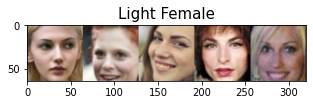

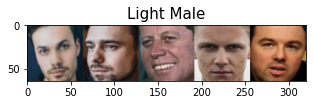

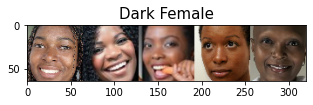

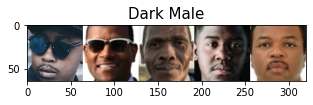

In [11]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#https://www.kaggle.com/sshikamaru/data-bias-reduction-with-vae-mit6s191
#Load test dataset and plot examples ###
test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

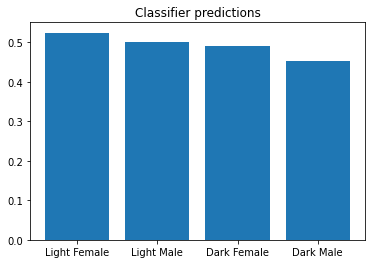

In [28]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Evaluate the standard CNN on the test data with the chart below:

standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.title("Classifier predictions");

Even if there is minimal variation in the model's predictive accuracy, this can still significantly affect certain groups of people if utilised in real-world applications.

So what steps can be taken to mitigate this?

We need to look at the CelebA dataset (not all 50 000 pictures). However, we can have a look and see the above inaccuracies could be based on the fact that the dataset has just more female faces than males. As a result, a classifier trained on CelebA will be better suited to recognise and classify faces with features similar to these and thus be biased.
(This is the most commonplace occurrence when working with pre-existing datasets)

Big tech companies have adopted the approach of labelling different subclasses, i.e. males with hats vs males without within their training data and then manually even it out.

As students, this would be impossible for us to do independently and would require weeks of annotating massive amounts of data. Secondly, we would have to know and look out for all the potential bias within the dataset without missing a single image, and as we know, this tedious manual method is prone to human errors.

If the manual annotation solution is not possible due to time constraints, there are other areas of de-biasing exploration:

**Variational autoencoder (VAE) for learning latent structure**

Our aim will be to try and train a debiased version of the same classifier as earlier, one that could account for potential disparities within the given dataset.

However, to be more specific about our aim, we want to build a debiased facial classifier.

How to:
1. Train a model that learns a representation of the underlying latent space to the face training data.
2. The model can then use that information to mitigate unwanted bias by sampling faces with rare features more frequently during the training.
3. Ensure that the model meets the requirement of learning how to encode latent features in the face data entirely unsupervised. (To achieve step three, we will enlist the help of VAEs(variational autoencoders))


Reference:
"An autoencoder is a simple generative model and a type of artificial neural network used to learn efficient data codings in an unsupervised manner and thus can be used for generative modeling and debiasing tasks." - See below.

Reference: https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.


Research:
https://www.researchgate.net/figure/Debiasing-Variational-Autoencoder-Architecture-of-the-semi-supervised-DB-VAE-for-binary_fig2_334381622 

Research paper: https://www.aies-conference.com/2019/wp-content/papers/main/AIES-19_paper_220.pdf

Let us try to understand how VAEs can help us.

VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. 
Regarding computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image used during training to help the model identify which latent variables are essential to learning.


The above explanation was taken and intepreted from the MIT lecture:
https://dspace.mit.edu/bitstream/handle/1721.1/121101/AIES_2019_Algorithmic_Bias.pdf?sequence=1&isAllowed=y 


Let's formalize two key aspects of the VAE model and define relevant functions for each.

1. Loss Function
2. Reparameterization

**Understanding VAEs: loss function**

The loss function of the variational autoencoder is the negative log-likelihood with a regularizer.

Cite:
https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

Cite:
https://jaan.io/what-is-variational-autoencoder-vae-tutorial/

Defining the VAE loss function:

In [29]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#https://www.oreilly.com/library/view/hands-on-convolutional-neural/9781789130331/5fd7b094-acd2-4a30-a916-e8cdd306f37b.xhtml#:~:text=In%20the%20VAE%2C%20our%20loss,mean%2C%20unit%20variance%20Gaussian%20distribution.

#Defining the VAE loss function

def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):

  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # latent_loss = # TODO

  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))

  vae_loss = kl_weight * latent_loss + reconstruction_loss
  
  return vae_loss

In [30]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#VAE Reparameterization
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  # z = # TODO
  return z

#Understanding VAEs: reparameterization 

"The “trick” part of the reparameterization trick is that you make the randomness an input to your model instead of something that happens “inside” it, which means you never need to differentiate with respect to sampling (which you can't do)." https://gregorygundersen.com/blog/2018/04/29/reparameterization/ 


Cite: https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important

Cite:
https://towardsdatascience.com/reparameterization-trick-126062cfd3c3

Let's define a function to implement the VAE sampling operation:

**Debiasing variational autoencoder (DB-VAE)**


So now that we have seen the architecture and more or less understood what is happening under the hood.
Let us try to train and DB-VAE model on the task of facial detection and run the debiasing operation during the training.
We can then evaluate and compare its accuracy to the original model we created.

Cite:
https://www.researchgate.net/figure/Debiasing-Variational-Autoencoder-Architecture-of-the-semi-supervised-DB-VAE-for-binary_fig2_334381622

What we hope the model can do:


We want to use the latent variables learned previously to adaptively re-sample the dataset during training.
We will try to alter the probability of a given image during the training based on how often the latent features appear in the dataset.
The faces with rarer features will become more likely to be sampled during the training, while the overrepresented samples will decrease in sampling.


### Defining the DB-VAE loss function

The loss function for the DB-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered. 

Cite: The above has been taken from the below sources.
https://www.mathworks.com/help/deeplearning/ug/train-a-variational-autoencoder-vae-to-generate-images.html


Cite:
https://medium.com/analytics-vidhya/vae-generative-modelling-for-face-recognition-71e8ba16950c

DB-VAE loss function:


In [31]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#https://www.kaggle.com/sshikamaru/data-bias-reduction-with-vae-mit6s191
#https://stackoverflow.com/questions/60327520/keras-variational-autoencoder-loss-function

#Loss function for DB-VAE


def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)

  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  # samples
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )

  return total_loss, classification_loss

DB-VAE structure:

To build the DB-VAE, we need to use the above CNN classifier as our encoder and define the decoder.
We then need to use 200 latent variables.
We need to initialize the two models created and then construct an end to end VAE.


Cite: Why  use end-to-end VAE:
https://people.csail.mit.edu/rosman/papers/iros-2018-variational.pdf

Cite:
https://www.researchgate.net/post/Why-latent-variable-correlations-are-much-higher-compared-to-observed-variable-correlations

In [32]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Define the decoder portion of the DB-VAE

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 200 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

Now we need to place the two models together:

In [33]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Defining and creating the DB-VAE

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  # classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    # z = # TODO
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

How are we actually using DB-VAE to train a debiased facial detection classifier?

As the input images go through the network, the encoder learns an estimate in the latent space. 

We can use frequency distributions of each learned latent variable and then define the probability distribution of selecting a given data point.

We can then try to use the distributions used in training to re-sample our data.

Research: https://venturebeat.com/2019/01/26/mit-csail-researchers-propose-automated-method-for-debiasing-ai-algorithms/

First, we've defined a short helper function `get_latent_mu` that returns the latent variable means returned by the encoder after a batch of images is inputted to the network:


Cite: 
https://medium.com/analytics-vidhya/vae-generative-modelling-for-face-recognition-71e8ba16950c 

In [38]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

Resampling algorithm for DB-VAE

In [39]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Resampling algorithm for DB-VAE
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae)
    # mu = get_latent_mu('''TODO''') # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # bin_idx = np.digitize('''TODO''', '''TODO''') # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # TODO: normalize all probabilities
        p = p / np.sum(p)
        # p = # TODO
        
        training_sample_p = np.maximum(p, training_sample_p)
        # training_sample_p = # TODO
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Training the DB-VAE model on the CelebA/ImageNet training data:

Starting epoch 8/8
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

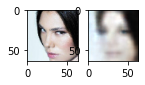

 15%|█▍        | 500/3434 [01:13<07:05,  6.90it/s]

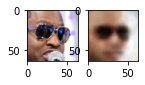

 29%|██▉       | 1000/3434 [02:27<05:54,  6.87it/s]

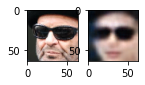

 44%|████▎     | 1500/3434 [03:40<04:52,  6.61it/s]

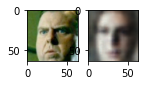

 58%|█████▊    | 2000/3434 [04:55<03:32,  6.74it/s]

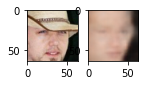

 73%|███████▎  | 2500/3434 [06:09<02:17,  6.80it/s]

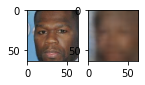

 87%|████████▋ | 3000/3434 [07:23<01:03,  6.89it/s]

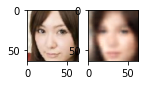

100%|██████████| 3434/3434 [08:29<00:00,  6.75it/s]


In [41]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

#Training the DB-VAE

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
num_epochs = 8

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    # loss, class_loss = debiasing_loss_function('''TODO arguments''') # TODO
  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables)
  # grads = tape.gradient('''TODO''', '''TODO''') # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae)
  # p_faces = get_training_sample_probabilities('''TODO''', '''TODO''') # TODO
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 500 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

Model Evaluation:

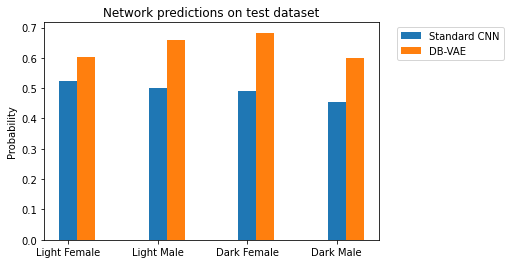

In [42]:
#https://medium.com/@kandgesid/debiasing-a-facial-detection-system-using-vaes-detailed-overview-cbf736db7fce#:~:text=An%20autoencoder%20is%20a%20simple,generative%20modeling%20and%20debiasing%20tasks.
#https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb

dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

#Conclusion:

Training time: 3hrs

Number of times model was trained: 5  

Epoch variation: 2, 6, 8, 10, 20

Based on the amount of training time and parameter variation, the above results have been the best thus far.

With the help of the DB-VAE, the network's predictions have become better at assessing facial features across each demographic.

Further exploration is required to consider this model a success, but first, in order to do so, we need to turn to the AI/ML model pipeline and see the areas where we can implement change.

AI/ML pipeline:

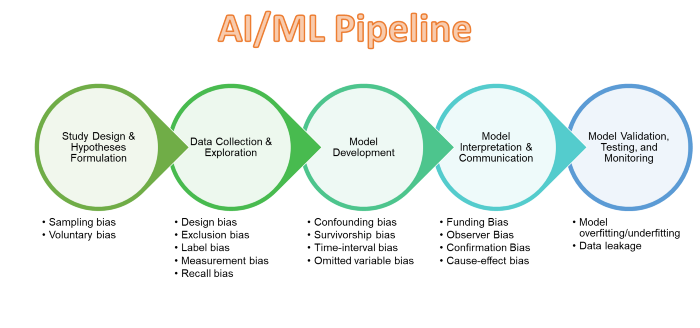


Cite: https://towardsdatascience.com/eliminating-ai-bias-5b8462a84779

As we can see in the above diagram, bias can occur from the absolute beginning of the cycle, with sampling bias (where only a subset of the given population has been sampled), data collection, pre-processing, and exploration.
This is just a few of the instances where bias can occur.

So how can we prevent bias?

When deciding on what data and features to include in any research, focus on the study's design. Aim to make the sample dataset representative of the target population. In short, we need to implement more intention into selection and data curation.

Other measures that we can take and good habits we can introduce before starting any project are:

We can use existing toolkits to assist with AI bias mitigation, and thorough training must be taught throughout a business. It can be implemented at the learning stage at universities, so an individual can critically assess a model's output and enable their understanding of AI/ML algorithms and question their validity.

Examples:
https://pypi.org/project/bias-detector/

https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-data-bias.html

https://colab.research.google.com/github/tensorflow/fairness-indicators/blob/master/g3doc/tutorials/Facessd_Fairness_Indicators_Example_Colab.ipynb#scrollTo=ZF4NO87uFxdQ - Still in BETA 


Further exploration:
The model can be tested on either more datasets, different datasets, a change in activation functions, or running a GAN-based de-bias model against a standared CNN.

Another avenue of further exploration could be about a de-biasing search engine results.
For example, Google vs duck duck go, when given a specific word and the output is not as diverse as we would expect it to be 
Example word: Beautiful

Cite:

https://www.wwt.com/article/mitigating-bias-in-ai-using-debias-gan